In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import random

## Mean Shift Segmentation Implementation 
## Each vector/point is in $5D$ space $(x,y, R,G,B)$.
## Using a Gaussian kernel for mean shift procedure with spatial standard deviation $\sigma_{sp}$ and intensity standard deviation $\sigma_{int}$.
##  While performing the mean shift iterations on any point, the weighted average is computed using a square of length 'r' centered at $(x_t , y_t)$ where $(x_t , y_t )$ are the spatial coordinates of the point in the current iteration (note that these spatial coordinates will change in every iteration).
## Given the filtered image, we will now perform segmentation on it using $K$-means in the joint spatial and intensity space, using some $K$. 

In [7]:
img =  cv.imread('path/parrot.png')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

In [8]:
X = [] # will contain feauture vectors/ samples
n = img.shape[0] #  rows
m = img.shape[1] # columns

# making feature vectors/samples
for i in range(0, n):
    for j in range(0, m):
        temp = []
        temp.append(i)
        temp.append(j)

        for k in range(0, 3):
            temp.append(img[i][j][k])

        X.append(np.asarray(temp))

X = np.vstack(X)
X = X.T # features * samples

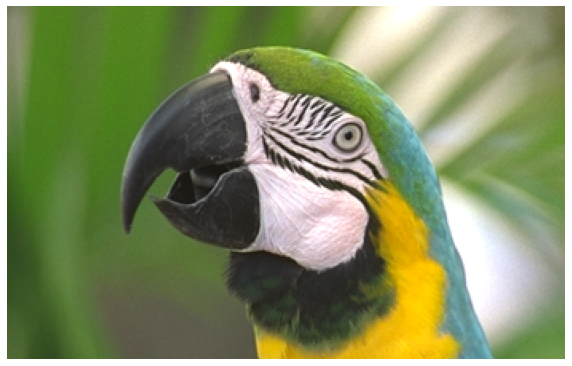

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

In [49]:
# function to extract Feature Vectors from images:
def getfeatures(img):
    '''
    img - image 
    '''
    X = [] # will contain feauture vectors/ samples
    n = img.shape[0] #  rows
    m = img.shape[1] # columns

    # making feature vectors/samples
    for i in range(0, n):
        for j in range(0, m):
            temp = []
            temp.append(i)
            temp.append(j)

            for k in range(0, 3):
                temp.append(img[i][j][k])

            X.append(np.asarray(temp))

    X = np.vstack(X)
    X = X.T # features * samples
    
    return X

# function to implement Multivariate Gaussian Kernel
def KDE_multivariate_gaussian(x, X, sigmas):
    '''
    x - feature vector to calculate KDE for aka bandwidth, dim(d,1)
    X - data, dim(d, m)
    sigmas - list of sigma/ std. dev. for each dimension

    Output:
    values: a vector giving kernel values for x in the neighbourhood X or K(x - xi) , dim - (m,)
    '''
    sigma = np.eye(5)
    np.fill_diagonal(sigma, np.square(sigmas)) # diagonal matrix with sigma^2 for each dimension

    d = X.shape[0]
    m = X.shape[1]
    
    exp = -1 * np.dot(np.dot((x - X.T), np.linalg.inv(sigma)), (x - X.T).T) # exponent part of the KDE equation

    exp = exp.diagonal() 
    
    exponent = np.exp(exp)

    values = (1/np.power(2*np.pi, (d/2)) * np.power(np.linalg.det(sigma), 1/2)) * exponent 

    return values

# function to get the weighted mean of the density over some neighbourhood X
def mean_x(X, values):
    '''
    X - data, dim(d, m)
    values - a vector giving kernel values for x, len - m

    Output:
    m_x = weighted mean of the density
    '''

    d = X.shape[0]
    m = X.shape[1]

    X_ = X.copy()

    # computing K(x - xi).xi, for each xi belonging to X
    for i in range(0, m):
        X_[:, i] = X_[:, i] * values[i] 

    numerator = np.sum(X_, axis = 1) # summation over K(x - xi).xi

    denominator = np.sum(values) # summation over K(x - xi)

    m_x = numerator / denominator # computing weighted mean
    
    return m_x

# function to compute euclidean distance between vector x and y
def dist(x, y):
    '''
    x - dim(5,)
    y - dim(5,)
    returns calculated distance
    '''
    return np.sqrt(np.sum(np.square(x - y)))

# function to implement mean shift 
def mean_shift(img, X, sigmas, radius):
    '''
    img - image for segmentation
    X - data, dim(d, m)
    sigma - list of sigma/ std. dev. for each dimension, aka badwidth
    radius - window to calculate mean on
    '''

    m = X.shape[1]
    
    epsilon = 0.00000001 # a small value used for convergence criteria
    
    X_ = X.copy()
    
    # compute over each feature vector/ sample 
    for i in range(0, m):
        
        shifting = True
        
        # for the feature vector/ sample i in X, calculate the nighbourhood 
        neighbourhood = []
        x_ = [x  for x in range(X[0][i] - int(radius/2), X[0][i] + int(radius/2)) if x>=0 and x<img.shape[0]]
        y_ = [x  for x in range(X[1][i] - int(radius/2), X[1][i] + int(radius/2)) if x>=0 and x<img.shape[1]]
        for x in x_:
            for y in y_:
                k = img.shape[1] * x + y
                neighbourhood.append(X[:, k])
                
        neighbourhood = np.asarray(neighbourhood)

        while shifting:
            values = KDE_multivariate_gaussian(X_[:, i], neighbourhood.T, sigmas) # get Kernel values
            prev_value = X_[:, i].copy()
            X_[:, i] = mean_x(neighbourhood.T, values) # calculate the weighted mean and shift the sample to the mean
            if dist(X_[:, i], prev_value) < epsilon: # convergence criteria
                shifting = False
            
        X_[0:2, i] = X[0:2, i] # change the index values to the original sample's index for reconstructing the image from
        
        if(i%1000 == 0): # to check progress
            print("On sample ", i)
    
    return X_

# a utility for reconstructing images from the Feature Vector/ Sample Space
def reconstruct(img, X):
    '''
    img - original image
    X - data, dim(d, m)
    
    img_reconstructed - reconstructed image is returned
    '''
    x = img.shape[0]
    y = img.shape[1]
    
    img_reconstructed = np.zeros((x, y, 3))
    for i in range(0, x):
        for j in range(0, y):
            img_reconstructed[i][j] = X[2:5, y * i + j]
            
    return img_reconstructed.astype('uint8')

# funtion to implement K Means clustering for segmentation
def k_means(X, k, img, iterations):
    '''
    X - data, dim(d, m)
    k - number of clusters
    img - original image
    iterations - number of iterations for cluster centres to be recalculated
    '''
    x = img.shape[0]
    y = img.shape[1]
    
    d = X.shape[0]
    m = X.shape[1]
    c_centres = []
    
    # get k random indices
    random_indices = random.sample(range(0, m), k)
    
    # assign random cluster centres
    for i in range(0, k):
        c_centres.append(np.asarray(X[:,random_indices[i]]))
        
    c_centres = np.vstack(c_centres)
    c_centres = c_centres.T
    
    cluster_index = np.zeros((m), dtype = np.uint) # will contain index of the nearest cluster centre
    
    for l in range(0, iterations):
        # calculate min distances for each sample to the cluster centres and assign them cluster centres
        for i in range(0, m):
            min_distance = dist(X[:, i], c_centres[:, 0])
            min_index = 0
            for j in range(1, k):
                distance = dist(X[:, i], c_centres[:, j])
                if distance < min_distance:
                    min_distance = distance
                    min_index = j
            cluster_index[i] = min_index

        # re-calculate cluster centres
        for i in range(0, k):
            cluster = []
            for j in range(0, m):
                if i == cluster_index[j]:
                    cluster.append(X[:,j])

            cluster = np.asarray(cluster).T
            # recalculating cluster centre as the average of all its cluster members
            c_centres[:, i] = (1/cluster.shape[1]) * np.sum(cluster, axis = 1) 
        
        print("Iteration: ", l+1)
            
    X_ = X.copy()
    
    # assigning all cluster member the average colour pixels values
    for i in range(0, m):
        ind = cluster_index[i]
        X_[2:5, i] = c_centres[2:5, ind]
    
    return X_


In [11]:
X_prime = mean_shift(img, X, [10.5,10.5,21,21,21], 23)

On sample  0
On sample  1000
On sample  2000
On sample  3000
On sample  4000
On sample  5000
On sample  6000
On sample  7000
On sample  8000
On sample  9000
On sample  10000
On sample  11000
On sample  12000
On sample  13000
On sample  14000
On sample  15000
On sample  16000
On sample  17000
On sample  18000
On sample  19000
On sample  20000
On sample  21000
On sample  22000
On sample  23000
On sample  24000
On sample  25000
On sample  26000
On sample  27000
On sample  28000
On sample  29000
On sample  30000
On sample  31000
On sample  32000
On sample  33000
On sample  34000
On sample  35000
On sample  36000
On sample  37000
On sample  38000
On sample  39000
On sample  40000
On sample  41000
On sample  42000
On sample  43000
On sample  44000
On sample  45000
On sample  46000
On sample  47000
On sample  48000
On sample  49000
On sample  50000
On sample  51000
On sample  52000
On sample  53000
On sample  54000
On sample  55000
On sample  56000
On sample  57000
On sample  58000
On sample 

(221, 350, 3)


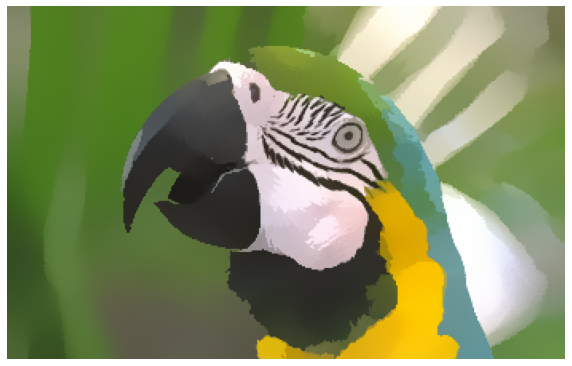

In [12]:
img_r = reconstruct(img, X_prime)
plt.figure(figsize=(10,10))
plt.imshow(img_r, cmap='gray')
plt.axis('off')
plt.show()

In [51]:
X_dprime = k_means(X_prime, 100, img, iterations = 3)

Iteration:  1
Iteration:  2
Iteration:  3


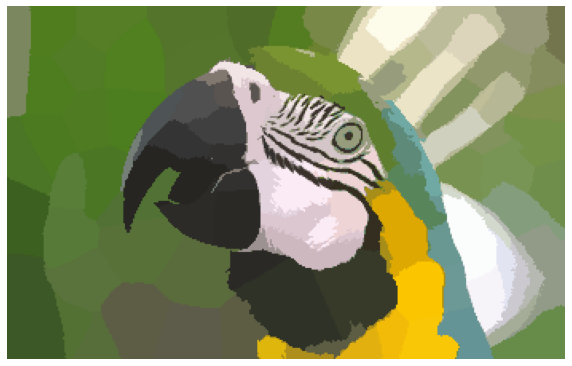

In [52]:
img_rprime = reconstruct(img, X_dprime)
plt.figure(figsize=(10,10))
plt.imshow(img_rprime, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
# Parameters
sigma_sp = 10.5 # should be in range [9,12]
sigma_int = 10.5 # should be in range [18,25]
radius = 23 # radius to calculate neigbourhood
k = 100 # K for K Means Clustering